In [243]:
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import interpolate 
sys.path.append(r'C:\Chuji\Code_and_Data\MyCode')

import Circuit_Simulator 
import PulseGenerator as PG
from toolfunc import *
from toolfunc.adia_analysis import *
from toolfunc.pulse_filter import *
import scipy.optimize as sci_op
from toolfunc import DE

{'Q1_freq': '6000.0MHz', 'Q1_anhar': '-125.0MHz', 'Q2_freq': '1000.0MHz', 'Q2_anhar': '-50.0MHz', 'Q3_freq': '5800.0MHz', 'Q3_anhar': '-125.0MHz', 'g12': '97.9796MHz', 'g13': '-23.5966MHz', 'g23': '96.3328MHz'}


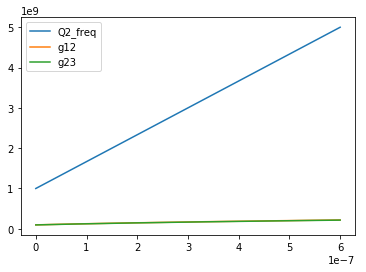

In [244]:
raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='ground',sampling_rate=1e9)
raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)

flux_pulse = np.linspace(1,0,601)
# flux_pulse = np.linspace(8/9,0/9,6000)
freq_arr =5e9 -flux_pulse * (5e9 - 1e9)

raw_config.setValue('Q1 f01_max',6.00e9)
raw_config.setValue('Q2 f01_max',5e9)
raw_config.setValue('Q3 f01_max',5.8e9)
raw_config.setValue('Q1 f01_min',1e9)
raw_config.setValue('Q2 f01_min',1e9)
raw_config.setValue('Q3 f01_min',1e9)
raw_config.setValue('Q1 Ec',0.25e9)
raw_config.setValue('Q2 Ec',0.1e9)
raw_config.setValue('Q3 Ec',0.25e9)

raw_config.setValue('r12',0.04)
raw_config.setValue('r23',0.04)
raw_config.setValue('r13',-0.004)

raw_config.setValue('Q2 Voltage period',-1)
raw_config.setValue('Q2 Voltage operating point',0)
raw_config.setValue('Q2 Flux',flux_pulse)

# raw_config.setValue('Uniform XY LO',True)
# raw_config.setValue('XY LO Freq',5.94e9)

simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
Simulator = Circuit_Simulator.Simulator(simu_config)
Simulator.show_pulse()

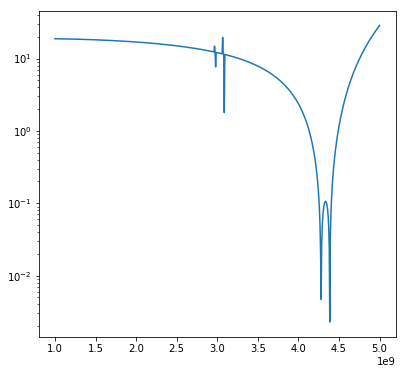

In [245]:
Simulator.performsimulation(solver_type=2,resample_factor=1,eigen_cloest_to_bare=False ,sort_by_maximum_overlap=True,gap=12e6)

fig = plt.figure(figsize=[6.4,6])
ax = fig.add_subplot(111)

eigen_trace = Simulator.EigenResult.get_Ener_gap_trace('101-100-001+000')
ax.plot(freq_arr,np.abs(eigen_trace)/1e6)

ax.set_yscale('log')

In [240]:
%matplotlib inline

In [211]:
gate_time=30e-9
SRATE=10e9
total_len = gate_time + 10e-9
Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
Seq.clear_pulse(tips_on=False)
Seq.add_pulse('Cosine',t0=total_len/2,width=40e-9,plateau=0e-9,amplitude=0.3255,frequency=0,half_cosine=False)
Seq.add_filter('Gauss Low Pass',300e6)
flux_pulse=Seq.get_sequence()
plt.plot(flux_pulse)

In [7]:
%matplotlib qt

In [236]:
def cost_func(pulse_params,*args):
    gate_time,SRATE=args
    amplitude = pulse_params
    total_len = gate_time + 16e-9
    
    Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
    Seq.clear_pulse(tips_on=False)
    Seq.add_pulse('Cosine',t0=total_len/2,width=gate_time-0e-9,plateau=0e-9,amplitude=amplitude,frequency=0,half_cosine=False)
    Seq.add_filter('Gauss Low Pass',300e6)
    flux_pulse=Seq.get_sequence()
        
    raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='-Z+Z+Z',sampling_rate=SRATE)
    raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)
    raw_config.setValue('Q1 f01_max',6.00e9)
    raw_config.setValue('Q2 f01_max',3.82e9)
    raw_config.setValue('Q3 f01_max',5.8e9)
    raw_config.setValue('Q1 f01_min',1e9)
    raw_config.setValue('Q2 f01_min',1e9)
    raw_config.setValue('Q3 f01_min',1e9)
    raw_config.setValue('Q1 Ec',0.25e9)
    raw_config.setValue('Q2 Ec',0.1e9)
    raw_config.setValue('Q3 Ec',0.25e9)
    raw_config.setValue('r12',0.05)
    raw_config.setValue('r23',0.05)
    raw_config.setValue('r13',-0.004)
    raw_config.setValue('Q2 Voltage period',-1)
    raw_config.setValue('Q2 Voltage operating point',0)
    raw_config.setValue('Q2 Flux',flux_pulse)

    simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
    Simulator = Circuit_Simulator.Simulator(simu_config)

    Simulator.performsimulation(solver_type=1)
    Simulator.UnitaryResult.get_U(-1)
    Simulator.UnitaryResult.get_subspace_operator(['000','001','100','101'])
    Simulator.UnitaryResult.remove_single_qubit_gate()
    Simulator.UnitaryResult.set_Target_gate('CZ')
    Simulator.UnitaryResult.get_Gate_Fidelity()
    fidelity = Simulator.UnitaryResult.Gate_Fidelity

    print('amplitude:',amplitude)
    print('error:',1-fidelity)
    return 1 - fidelity

In [237]:
raw_initial_seeds = [0.4]
gate_time=60e-9
SRATE=10e9
DATA = sci_op.minimize(cost_func,raw_initial_seeds,args=(gate_time,SRATE), method='Nelder-Mead', options={'disp': True,'ftol':1e-5,'xtol':1e-5,'maxiter':30})

amplitude: [0.4]
error: 0.1489653870276676
amplitude: [0.42]
error: 0.1229004161202687
amplitude: [0.44]
error: 0.10059311311622288
amplitude: [0.46]
error: 0.08253327670300659
amplitude: [0.5]
error: 0.05767686039008191
amplitude: [0.54]
error: 0.04605578130983268
amplitude: [0.62]
error: 0.05176713564931312
amplitude: [0.58]
error: 0.04497290322805958
amplitude: [0.62]
error: 0.05176713564931312
amplitude: [0.56]
error: 0.04440754208889319
amplitude: [0.54]
error: 0.04605578130983723
amplitude: [0.57]
error: 0.044405226986077184
amplitude: [0.58]
error: 0.0449729032280588
amplitude: [0.565]
error: 0.04431796358659168
amplitude: [0.56]
error: 0.04440754208889319


KeyboardInterrupt: 

In [29]:
SRATE=10e9
gate_time_arr = np.arange(16e-9,60.1e-9,1e-9)

gate_fidelity_cos = []
gate_params_cos = []
raw_initial_seeds=np.array([0.28])
for gate_time in gate_time_arr:
    time_start = time.time()
    DATA = sci_op.minimize(cost_func,raw_initial_seeds,args=(gate_time,SRATE), method='Nelder-Mead', options={'disp': True,'ftol':1e-5,'xtol':1e-5,'maxiter':30})

    gate_fidelity_cos.append(DATA.fun)
    gate_params_cos.append(DATA.x)
    raw_initial_seeds =DATA.x*0.92
    print('gate time',gate_time)
    print('fidelity',DATA.fun)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\params_cos.txt',gate_params_cos )
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\error_cos.txt',gate_fidelity_cos )
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\gate_time_cos.txt',gate_time_arr )
   